# Lab Activity: Predicting Nationality from Names using Machine Learning

## Tasneem Al Sheikh - 60104251

____________________________________

### Imports and Constants

In [1]:
import torch
from torch import nn
import glob
import unicodedata
import string
import random
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os

### Constants

In [2]:
MAX_LENGTH = 20
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
DATA_PATH = r"C:\Users\user\OneDrive\Desktop\Resources\Selected Topics in AI\Assignment1\names"
TRAIN_SPLIT = 0.8  # 80% training, 20% validation

________________

### Data Processing

The following functions and class handle data loading and preprocessing. The `NameDataset` class loads name files and converts them into a format suitable for training.


### Helper Functions

In [3]:
def unicode_to_ascii(s):
    """Convert Unicode string to ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters + " -'"
    )

class NameDataset:
    def __init__(self, data_dir):
        self.all_letters = string.ascii_letters + " -'"
        self.n_letters = len(self.all_letters)
        self.names = []
        self.nationalities = []
        self.nationality_to_ix = {}
        self.load_data(data_dir)

    def load_data(self, data_dir):
        """Load names from files and create indices."""
        file_pattern = os.path.join(data_dir, "*.txt")
        files = glob.glob(file_pattern)

        if not files:
            raise Exception(f"No .txt files found in {data_dir}")

        for filename in files:
            nationality = os.path.basename(filename).split('.')[0]
            if nationality not in self.nationality_to_ix:
                self.nationality_to_ix[nationality] = len(self.nationality_to_ix)

            with open(filename, encoding='utf-8') as f:
                for line in f:
                    name = unicode_to_ascii(line.strip())
                    if name:
                        self.names.append(name)
                        self.nationalities.append(self.nationality_to_ix[nationality])

        print(f"Loaded {len(self.names)} names from {len(self.nationality_to_ix)} nationalities")

    def name_to_tensor(self, name):
        """Convert name to tensor of character indices."""
        tensor = torch.zeros(MAX_LENGTH, dtype=torch.long)
        for i, char in enumerate(name[:MAX_LENGTH]):
            if char in self.all_letters:
                tensor[i] = self.all_letters.find(char)
        return tensor

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        nationality = self.nationalities[idx]
        return self.name_to_tensor(name), torch.tensor(nationality)


__________________________

### Model Architecture

The neural network model consists of an embedding layer followed by fully connected layers.


### Model Definition

In [4]:
class NameClassifier(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(NameClassifier, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * MAX_LENGTH, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.view(embedded.size(0), -1)
        hidden = self.fc1(embedded)
        hidden = self.relu(hidden)
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)
        return output

### Training and Evaluation Functions

These functions handle model training, evaluation, and performance visualization.


In [5]:
def calculate_accuracy(outputs, targets):
    """Calculate accuracy for a batch."""
    _, predicted = torch.max(outputs.data, 1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    return correct / total

def evaluate_model(model, data_loader):
    """Evaluate model on given data loader."""
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for names, nationalities in data_loader:
            outputs = model(names)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += nationalities.size(0)
            total_correct += (predicted == nationalities).sum().item()

    return total_correct / total_samples

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_acc = 0
        batch_count = 0

        for names, nationalities in train_loader:
            optimizer.zero_grad()
            outputs = model(names)
            loss = criterion(outputs, nationalities)
            loss.backward()
            optimizer.step()

            # Calculate batch accuracy
            acc = calculate_accuracy(outputs, nationalities)
            total_acc += acc
            total_loss += loss.item()
            batch_count += 1

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / batch_count
        avg_train_acc = total_acc / batch_count

        # Calculate validation accuracy
        val_acc = evaluate_model(model, val_loader)

        losses.append(avg_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Loss: {avg_loss:.4f}')
        print(f'  Training Accuracy: {avg_train_acc:.4f}')
        print(f'  Validation Accuracy: {val_acc:.4f}')

    return losses, train_accuracies, val_accuracies


_____________________________

### Visualization and Prediction Functions


Functions for plotting training metrics and making predictions.


In [6]:
def plot_metrics(losses, train_accuracies, val_accuracies):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(losses)
    ax1.set_title('Training Loss over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training')
    ax2.plot(val_accuracies, label='Validation')
    ax2.set_title('Model Accuracy over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def predict_nationality(model, dataset, name, top_k=3):
    model.eval()
    with torch.no_grad():
        name_tensor = dataset.name_to_tensor(name.lower()).unsqueeze(0)
        output = model(name_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_idx = torch.topk(probabilities, top_k)

        results = []
        ix_to_nationality = {v: k for k, v in dataset.nationality_to_ix.items()}
        for prob, idx in zip(top_prob[0], top_idx[0]):
            nationality = ix_to_nationality[idx.item()]
            results.append((prob.item(), nationality))

    return results


________________________________

### Model Training and Evaluation

Execute this block to train the model and evaluate its performance.


Loaded 20074 names from 18 nationalities
Epoch [1/15]:
  Loss: 1.3245
  Training Accuracy: 0.6119
  Validation Accuracy: 0.6919
Epoch [2/15]:
  Loss: 0.9766
  Training Accuracy: 0.7045
  Validation Accuracy: 0.7103
Epoch [3/15]:
  Loss: 0.8254
  Training Accuracy: 0.7441
  Validation Accuracy: 0.7462
Epoch [4/15]:
  Loss: 0.7187
  Training Accuracy: 0.7768
  Validation Accuracy: 0.7664
Epoch [5/15]:
  Loss: 0.6506
  Training Accuracy: 0.7979
  Validation Accuracy: 0.7704
Epoch [6/15]:
  Loss: 0.5917
  Training Accuracy: 0.8157
  Validation Accuracy: 0.7664
Epoch [7/15]:
  Loss: 0.5431
  Training Accuracy: 0.8273
  Validation Accuracy: 0.7748
Epoch [8/15]:
  Loss: 0.5034
  Training Accuracy: 0.8396
  Validation Accuracy: 0.7758
Epoch [9/15]:
  Loss: 0.4643
  Training Accuracy: 0.8512
  Validation Accuracy: 0.7823
Epoch [10/15]:
  Loss: 0.4338
  Training Accuracy: 0.8580
  Validation Accuracy: 0.7743
Epoch [11/15]:
  Loss: 0.3999
  Training Accuracy: 0.8680
  Validation Accuracy: 0.7858


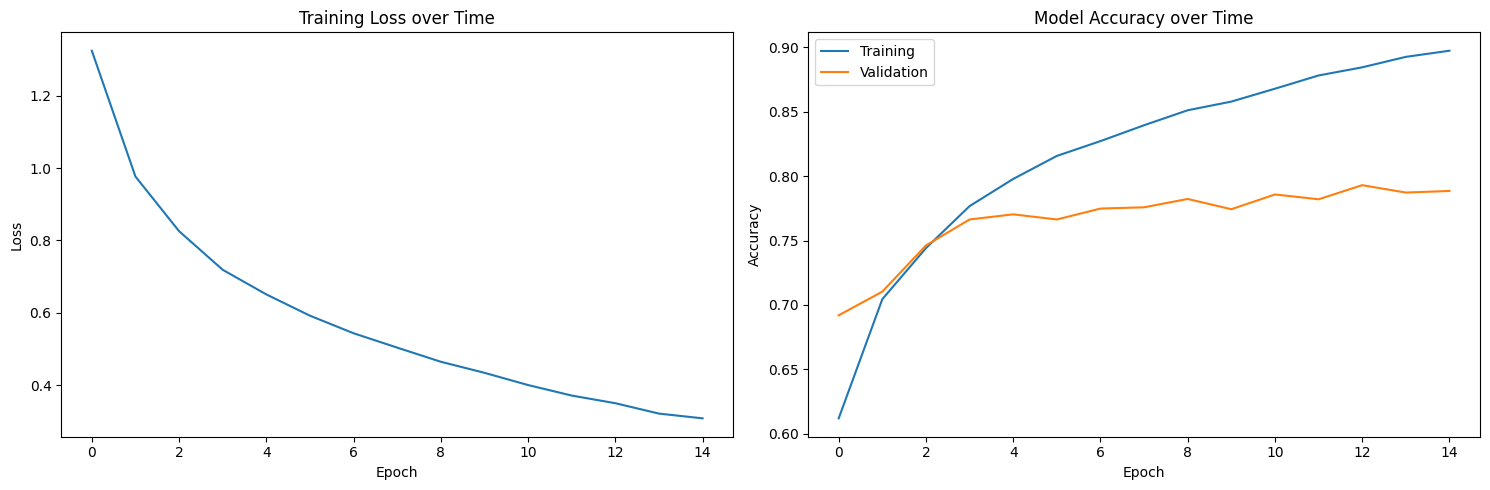


Final Model Performance:
Training Accuracy: 0.9222
Validation Accuracy: 0.7885


In [7]:
if __name__ == "__main__":
    if not os.path.exists(DATA_PATH):
        raise Exception(f"Directory not found: {DATA_PATH}")

    # Initialize dataset
    full_dataset = NameDataset(DATA_PATH)

    # Split dataset into training and validation sets
    train_size = int(TRAIN_SPLIT * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    model = NameClassifier(
        input_size=len(full_dataset.all_letters),
        embedding_dim=EMBEDDING_DIM,
        hidden_size=HIDDEN_SIZE,
        output_size=len(full_dataset.nationality_to_ix)
    )

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train the model
    losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS
    )

    # Plot training metrics
    plot_metrics(losses, train_accuracies, val_accuracies)

    # Final model evaluation
    final_train_acc = evaluate_model(model, train_loader)
    final_val_acc = evaluate_model(model, val_loader)

    print("\nFinal Model Performance:")
    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")


______________________________

### Make Predictions

Use this block to make predictions for specific names.


In [8]:
# Prompt the user for their name
name = input("Enter a name to predict nationality: ")

# Make predictions
predictions = predict_nationality(model, full_dataset, name)

# Display results
print(f"\nPredictions for '{name}':")
for prob, nationality in predictions:
    print(f"({prob:.2f}) {nationality}")



Predictions for 'Tasneem':
(0.56) English
(0.19) French
(0.14) Italian


In [9]:
torch.save(model.state_dict(), 'model.pth')